# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# read in the json files
portfolio = pd.read_json('/Users/ifunanya/Downloads/portfolio.json', orient='records', lines=True)
profile = pd.read_json('/Users/ifunanya/Downloads/profile.json', orient='records', lines=True)
transcript = pd.read_json('/Users/ifunanya/Downloads/transcript.json', orient='records', lines=True)

%matplotlib inline

## Getting an understanding of the different datasets

For this section, I'll be exploring the datasets to get an understanding of the datasets

### Portfolio dataset

In [2]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
portfolio.shape

(10, 6)

In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [6]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

### Profile dataset

In [7]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [8]:
profile.shape

(17000, 5)

In [9]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [10]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [11]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

### Transcript dataset

In [12]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [13]:
transcript.shape

(306534, 4)

In [14]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [15]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [16]:
transcript.person.nunique()

17000

In [17]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

### Data Cleaning and Preprocessing

As this phase will be crucial for modeling, the following steps will be involved in preprocessing:

##### For the portfolio dataset:
- Update the column name to merge later with other dataframes
- Seperate values from channels column into different columns with 0/1 value

##### For the profile dataset:
- Handling Missing Data: As observed, there are missing values in the profile dataset for gender, and income. These will be dropped.
- Replace age values with age groups for categorical analysis.
- Replace became_member_on with year format and rename to year
- Rename id to person to merge later with other dataframes

##### For the transcript dataset:
- Feature Engineering: Extracting relevant information from the value column in the transcript dataset, and possibly creating new features
- Merge two resulting columns
- Rename column for later merge with other datasets

We'd also be: 
- Encoding Categorical Data: Converting categorical variables such as gender and event into a format suitable for machine learning models.
- Merging Datasets: Combining the datasets to get a holistic view of user interactions with offers.
- Normalization: Standardizing numerical features to ensure they are on a similar scale.

In [18]:
# portfolio dataset

#rename columns
portfolio.rename(columns={'id':'offer_id'},inplace=True)

#seperate values from channels column
channels = set()
for i in portfolio.channels:
    channels.update(set(i))

for i in channels:
    portfolio[i] = portfolio.channels.apply(lambda x: 1 if i in x else 0)    

portfolio.drop(['channels'], axis=1, inplace=True)

portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,email,web,social,mobile
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


In [19]:
# profile dataset

# update age
profile['age'] = pd.cut(profile.age, bins=[0, 9, 19, 29, 39, 49, 59, 69, 79, 117, 200], 
                               labels=['children', 'YA', '20s', '30s', '40s', '50s', '60s', '70s','80+','NA'])

# update year
profile["became_member_on"] = pd.to_datetime(profile.became_member_on, format = '%Y%m%d').apply(lambda x:x.year)

# Dropping rows with missing values (age, gender, income)
profile.dropna(subset=['gender', 'income'], inplace = True)

# rename columns
profile.rename(columns={'id': 'person'}, inplace=True)
profile.rename(columns={'became_member_on': 'year'}, inplace = True)

profile.head()

,gender,age,person,year,income
1,F,50s,0610b486422d4921ae7d2bf64640c50b,2017,112000.0
3,F,70s,78afa995795e4d85b5d9ceeca43f5fef,2017,100000.0
5,M,60s,e2127556f4f64592b11af22de27a7932,2018,70000.0
8,M,60s,389bc3fa690240e798340f5a15918d5c,2018,53000.0
12,M,50s,2eeac8d8feae4a8cad5a6af0499a211d,2017,51000.0


In [20]:
profile.isnull().sum()

gender    0
age       0
person    0
year      0
income    0
dtype: int64

In [21]:
# Proceed with feature engineering for the transcript dataset by extracting relevant information from the value column

# Extracting 'offer id' or 'offer_id' from the value column
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer id', x.get('offer_id', None)))

# Extracting 'amount' from the value column for "transaction" events
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount', None))

# Extracting 'reward' from the value column for "offer completed" events
transcript['reward_received'] = transcript['value'].apply(lambda x: x.get('reward', None))

# fill null values
transcript.amount.fillna(0, inplace=True)
transcript.reward_received.fillna(0, inplace=True)

# Dropping the original 'value' column
transcript.drop(columns='value', inplace=True)

transcript.head()

,person,event,time,offer_id,amount,reward_received
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


In [22]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   person           306534 non-null  object 
 1   event            306534 non-null  object 
 2   time             306534 non-null  int64  
 3   offer_id         167581 non-null  object 
 4   amount           306534 non-null  float64
 5   reward_received  306534 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 14.0+ MB


### Data Visualization and Exploration

For further exploration, visualizations will be done

##### Profile Dataset:
- Distribution of gender
- Distribution of age
- Distribution of income
- Distribution of membership start date

##### Portfolio Dataset:
- Distribution of offer types
- Distribution of offer channels

##### Transcript Dataset:
- Distribution of event types
- Distribution of transaction amounts (for "transaction" events)


In [23]:
# define function to create countplots
def create_countplot(data, x_col, title, x_label, y_label):
    sns.countplot(data=data, x=x_col, order=data[x_col].value_counts().index)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

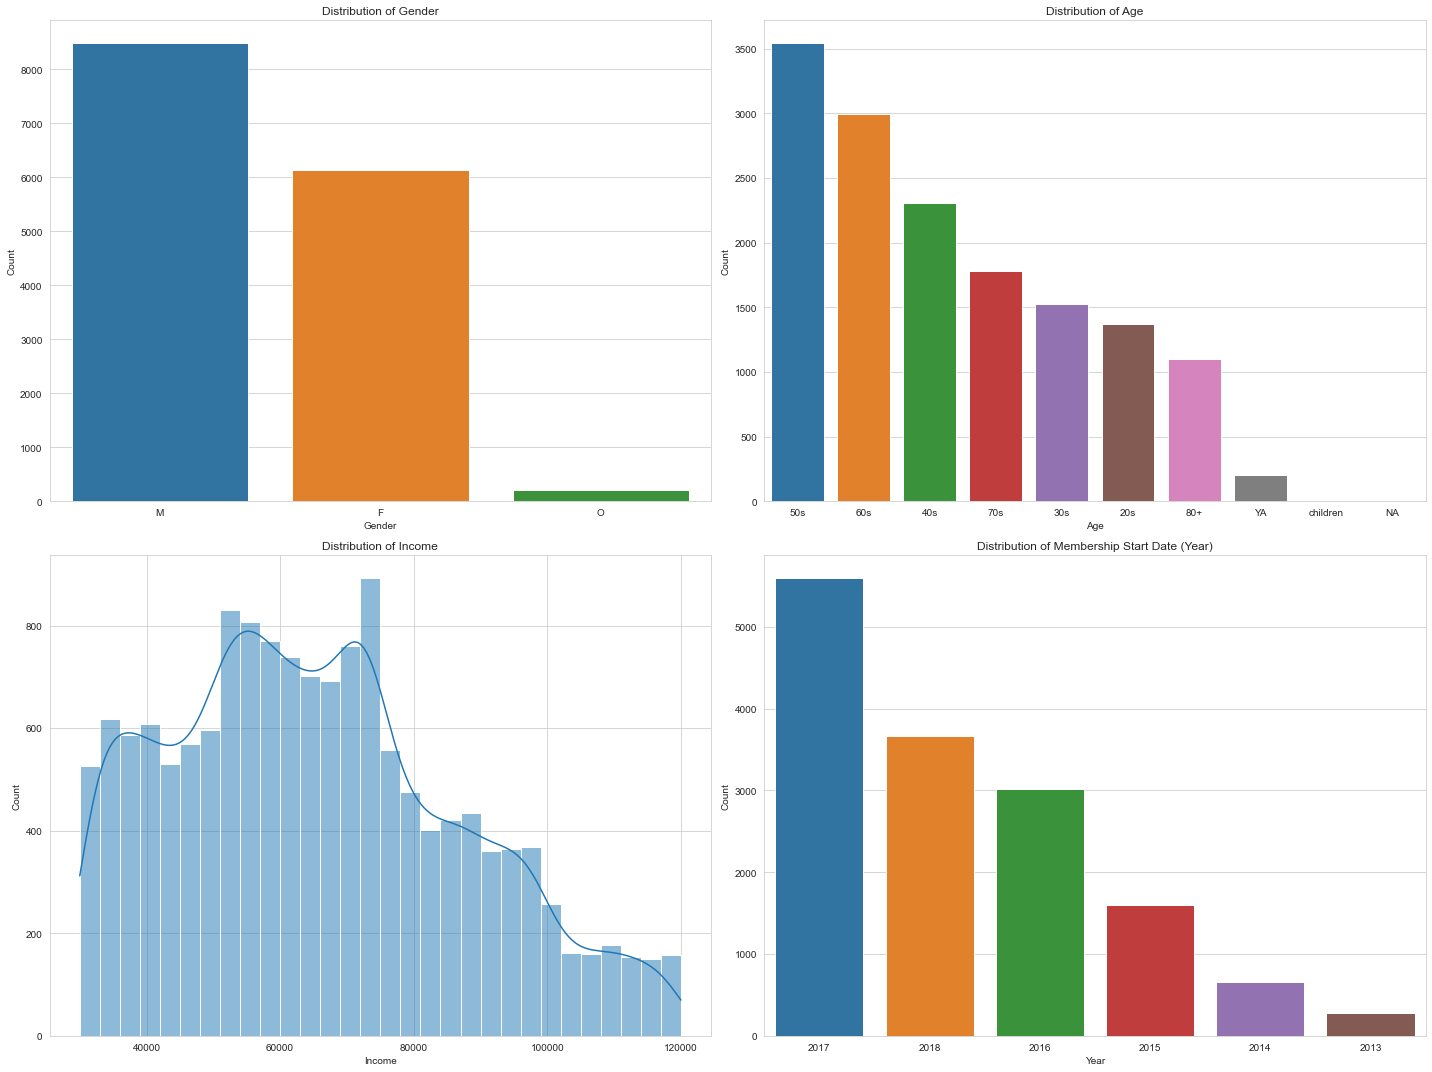

In [24]:
# Set up the plotting style
sns.set_style("whitegrid")

# Initialize the figure
plt.figure(figsize=(20, 15))

# Plotting distribution of gender
plt.subplot(2, 2, 1)
create_countplot(profile, 'gender', 'Distribution of Gender', 'Gender', 'Count')

# Plotting distribution of age
plt.subplot(2, 2, 2)
create_countplot(profile, 'age', 'Distribution of Age', 'Age', 'Count')

# Plotting distribution of income
plt.subplot(2, 2, 3)
sns.histplot(profile[profile['income'].notnull()]['income'], bins=30, kde=True)
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Count')

# Plotting distribution of membership start date
plt.subplot(2, 2, 4)
create_countplot(profile, 'year', 'Distribution of Membership Start Date (Year)', 'Year', 'Count')

# Display the plots
plt.tight_layout()
plt.show()

From the visualizations, here are some observations:

Distribution of Gender:
The dataset has a higher number of males compared to females, and a smaller number of other genders. The missing gender values were dropped.

Distribution of Age:
Most of the users are in the age range of 30-70 years.

Distribution of Income:
Income is somewhat normally distributed with a slight right skew, with most users earning between $50,000 and $80,000.

Distribution of Membership Start Date (Year):
There's a steady increase in new members from 2013 to 2017. However, there's a decline in new members in 2018. This could be because the data does not cover the entire year of 2018 or due to other factors.

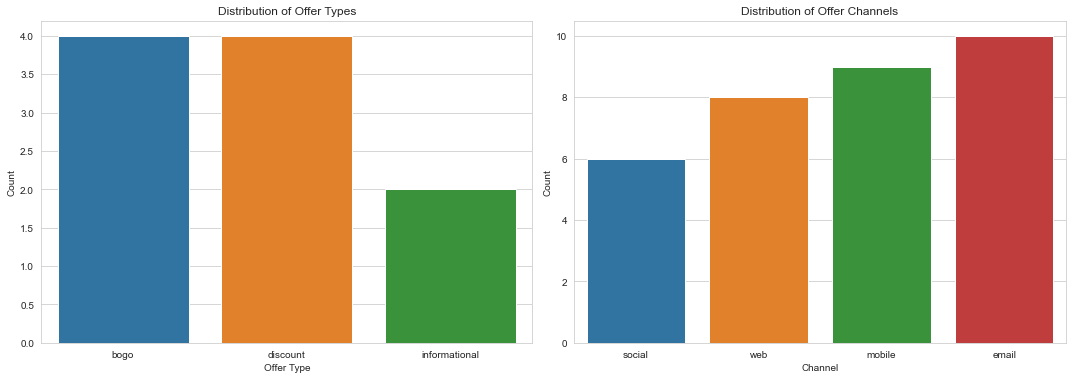

In [25]:
# Visualization for the Portfolio Dataset

# Initialize the figure
plt.figure(figsize=(15, 10))

# Plotting distribution of offer types
plt.subplot(2, 2, 1)
create_countplot(portfolio, 'offer_type', 'Distribution of Offer Types', 'Offer Type', 'Count')

# Plotting distribution of offer channels
# Initialize a list of channels
channels = ['social', 'web', 'mobile', 'email']

# Create a long format DataFrame by melting the channels
melted_portfolio = pd.melt(portfolio, id_vars=['offer_id'], value_vars=channels, var_name='channel', value_name='count')

# Filter the DataFrame to keep only rows where 'count' is 1
melted_portfolio = melted_portfolio[melted_portfolio['count'] == 1]

plt.subplot(2, 2, 2)
sns.countplot(data=melted_portfolio, x='channel')
plt.title('Distribution of Offer Channels')
plt.xlabel('Channel')
plt.ylabel('Count')

# Display the plots
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Frequency')

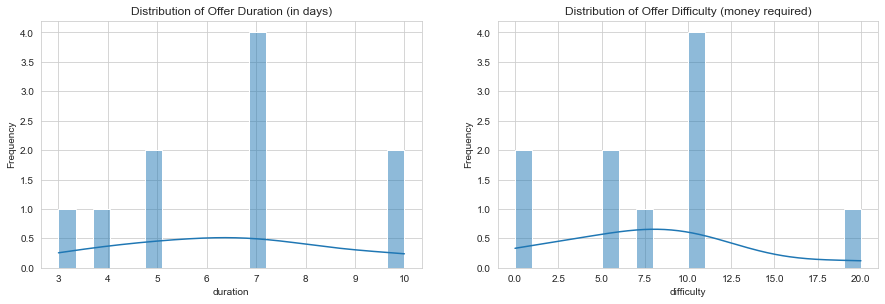

In [26]:
# Initialize the figure
plt.figure(figsize=(15, 10))

# Plotting the distribution of offer duration
plt.subplot(2, 2, 1)
sns.histplot(portfolio['duration'], bins=20, kde=True)
plt.title('Distribution of Offer Duration (in days)')
plt.ylabel('Frequency')

# Plotting the distribution of offer difficulty
plt.subplot(2, 2, 2)
sns.histplot(portfolio['difficulty'], bins=20, kde=True)
plt.title('Distribution of Offer Difficulty (money required)')
plt.ylabel('Frequency')

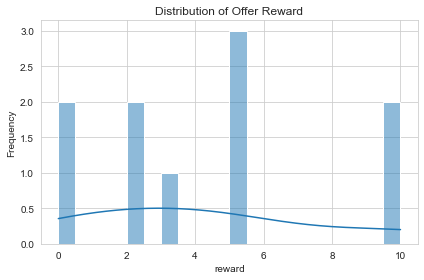

In [27]:
# Plotting the distribution of offer reward
sns.histplot(portfolio['reward'], bins=20, kde=True)
plt.title('Distribution of Offer Reward')
plt.ylabel('Frequency')

# Display the plots
plt.tight_layout()
plt.show()

Based on the visualizations, here are observations for the Portfolio Dataset:

Distribution of Offer Types:
There are three types of offers: BOGO (buy-one-get-one-free), discount, and informational. There's a roughly equal distribution of the two of the offer types: "bogo", "discount" with "informational" being slightly less common.

Distribution of Offer Channels:
"Email" appears to be the most common channel for sending offers, followed by "mobile", "social", and "web".
It's important to note that multiple channels can be used for a single offer, which is why the counts exceed the number of total offers.

Offer Duration:
Most offers have a duration of 5 to 10 days, with a few offers extending up to 7 days.

Offer Difficulty:
The "difficulty" indicates the amount of money a user needs to spend to avail the offer.
Many offers have a difficulty level set around 0-10 units (likely representing currency), with some offers requiring around 20 units of spend.

Offer Reward:
Rewards range between 0 to 10 units, with peaks around 5 and 10 units. This suggests that many offers provide substantial rewards to users if the offer conditions are met.

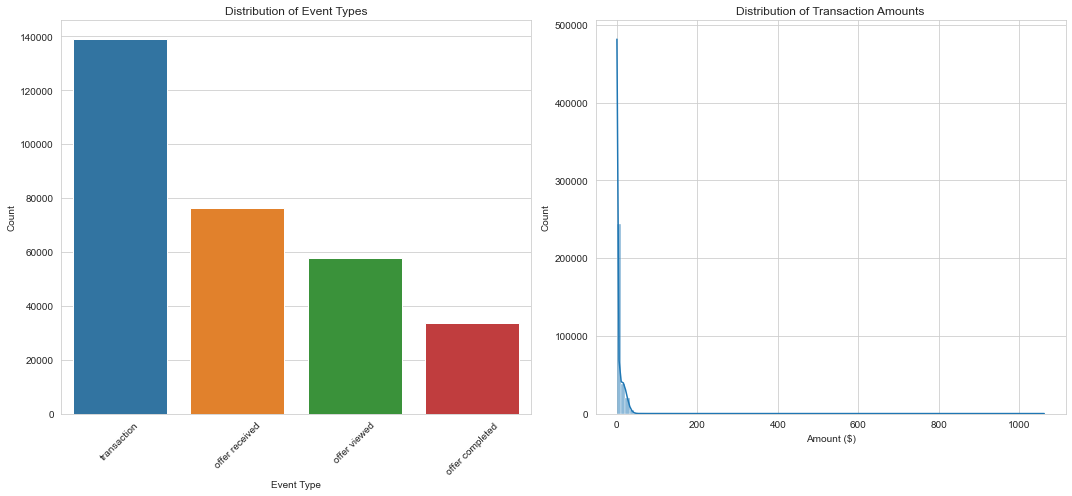

In [28]:
# Initialize the figure
plt.figure(figsize=(15, 7))

# Plotting distribution of event types
plt.subplot(1, 2, 1)
create_countplot(transcript, 'event', 'Distribution of Event Types', 'Event Type', 'Count')
plt.xticks(rotation=45)

# Plotting distribution of transaction amounts for "transaction" events
plt.subplot(1, 2, 2)
sns.histplot(transcript['amount'], bins=100, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount ($)')
plt.ylabel('Count')

# Display the plots
plt.tight_layout()
plt.show()

From the visualizations here are observations for the Transcript Dataset:

Distribution of Event Types:
The most frequent event is "transaction", indicating the number of purchases made.
"Offer received" events are also prevalent, followed by "offer viewed" and "offer completed". This sequence suggests that not all offers received are viewed, and among those viewed, not all are completed.

Distribution of Transaction Amounts:
Most transactions are of smaller amounts, with a peak below $20.
The distribution has a right skew, meaning there are fewer high-value transactions, but they do exist.
With these visualizations, we now have a clearer understanding of the data distributions and potential areas of interest.

The next steps involve diving deeper into the data to derive insights and prepping the data for modeling.

### Further Exploration

I'll also be exploring the relationship between user demographics and their interactions with the offers. 

We can investigate:
- How different genders respond to offers.
- The impact of income and age on offer interactions

In [29]:
def create_plot(data, title, xlabel, ylabel):
    data.plot(kind = 'bar', figsize = (14,7))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation = 0)
    plt.tight_layout()
    plt.show()

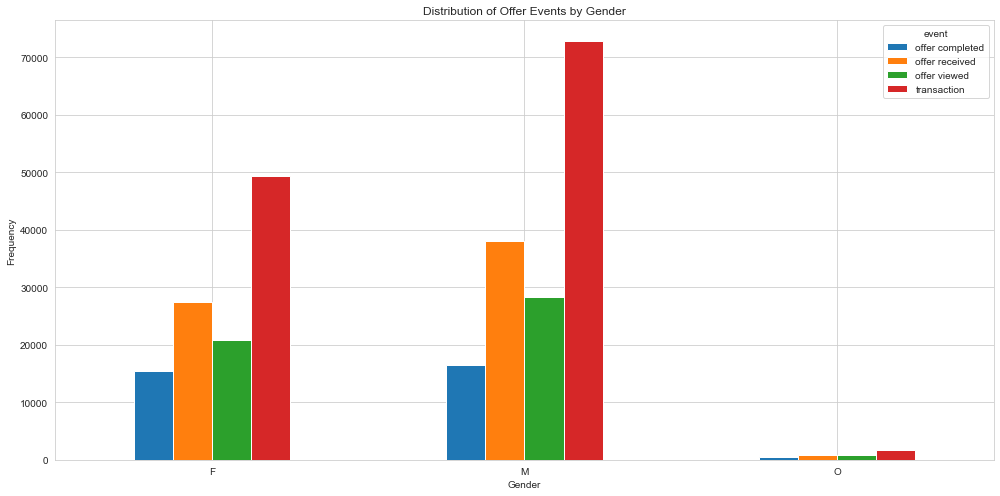

In [30]:
# Merging the profile and transcript datasets on user ID
merged_data = pd.merge(transcript, profile, left_on='person', right_on='person', how='inner')

# Grouping the data by gender and event type to see the distribution of events for each gender
gender_event_counts = merged_data.groupby(['gender', 'event']).size().unstack().fillna(0)

# Plotting the distribution
create_plot(gender_event_counts, 'Distribution of Offer Events by Gender', 'Gender', 'Frequency')

The bar plot depicts the distribution of offer events by gender:

Transactions:
All genders have a significant number of transactions, with males having the highest number.
This suggests that many users make purchases without necessarily being influenced by an offer.

Offer Received:
All genders receive a significant number of offers. Males receive the most offers, followed by females and then the "Other" gender category.

Offer Viewed:
The trend in offer viewing is similar to the offer received distribution. Males view the most offers, followed by females and the "Other" category.

Offer Completed:
Males complete the most offers, followed by females. However, the rate of offer completion (compared to the number of offers viewed) is higher for females than for males.

Next, we'll investigate the impact of income and age on offer interactions. We'll start by examining how income levels influence the types of offers users respond to.

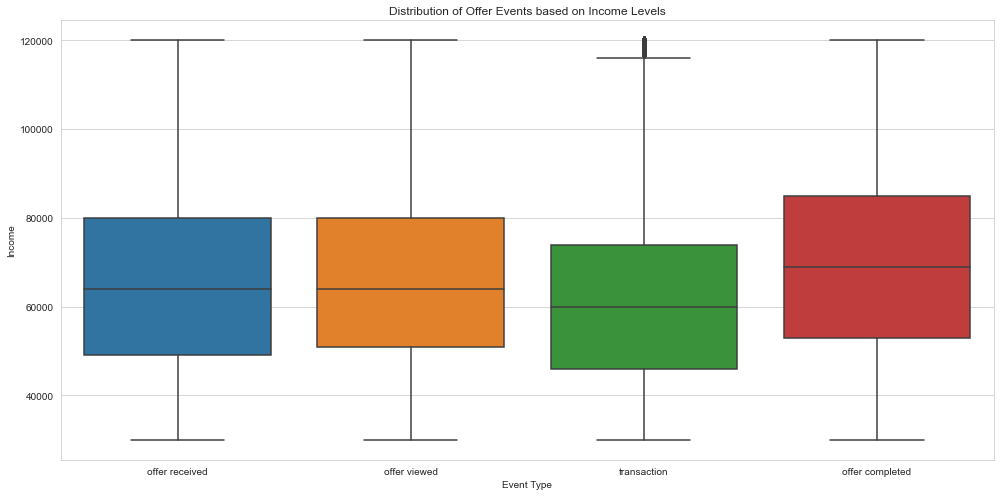

In [31]:
# Merging the cleaned transcript data with profile data
merged_data = pd.merge(transcript, profile, on='person', how='inner')

# Plotting the distribution of offer events based on income levels
plt.figure(figsize=(14, 7))
sns.boxplot(data=merged_data, x='event', y='income')
plt.title('Distribution of Offer Events based on Income Levels')
plt.xlabel('Event Type')
plt.ylabel('Income')
plt.tight_layout()
plt.show()

The box plot shows the distribution of offer events based on income levels:

Offer Completed: The median income for those who completed the offers is slightly higher compared to other events. This suggests that users with higher incomes are more likely to complete offers.

Offer Received: The median income level for users receiving offers is consistent with the overall median income of the dataset. The distribution appears to be balanced.

Offer Viewed: The distribution is similar to the "Offer Received" event.

Transaction: The income distribution for general transactions (without considering offers) is slightly lower than the "Offer Completed" event.

From the above observations, it seems that higher income users are more inclined to complete offers. However, the overall income distribution remains relatively consistent across all event types.

Next, we can examine how the age of users influences their interactions with the offers. 

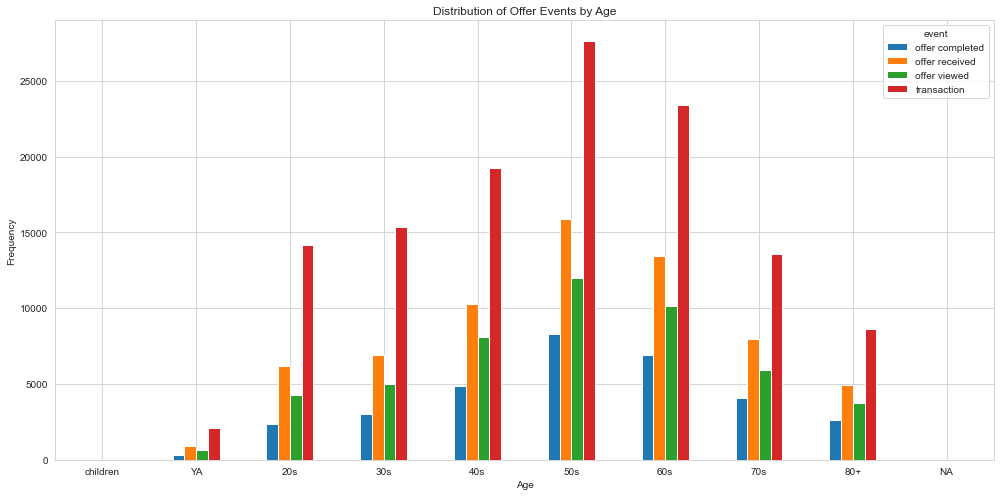

In [32]:
# Plotting the distribution of offer events based on age

age_event_counts = merged_data.groupby(['age', 'event']).size().unstack().fillna(0)

# Plotting the distribution
create_plot(age_event_counts, 'Distribution of Offer Events by Age', 'Age', 'Frequency')

Users aged 30 - 60s received the most offers and expectedly, viewed and completed the most offers. They also carried out the highest number of transactions.

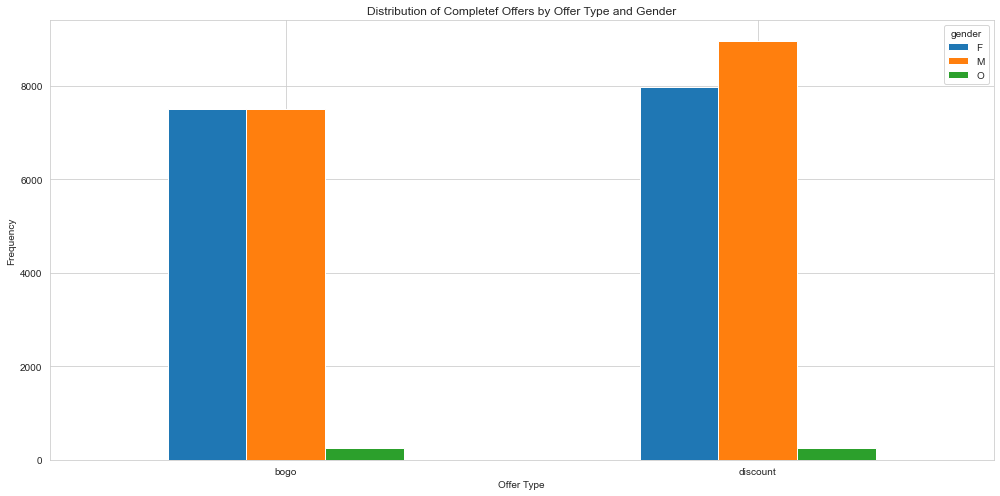

In [33]:
# Merging the merged_data with portfolio to get offer details
merged_data_offer = pd.merge(merged_data, portfolio, on='offer_id', how='left')

# Filtering the data for 'offer completed' events
completed_offers = merged_data_offer[merged_data_offer['event'] == 'offer completed']

# Grouping the data by offer type and gender to see the distribution of completed offers for each gender
offer_gender_counts = completed_offers.groupby(['offer_type', 'gender']).size().unstack().fillna(0)

# Plotting the distribution
create_plot(offer_gender_counts, 'Distribution of Completef Offers by Offer Type and Gender', 'Offer Type', 'Frequency')

Both genders have a good number of completed offers. More males seem to complete discount offers; however, this is not unexpected given that more males make up the customer base.

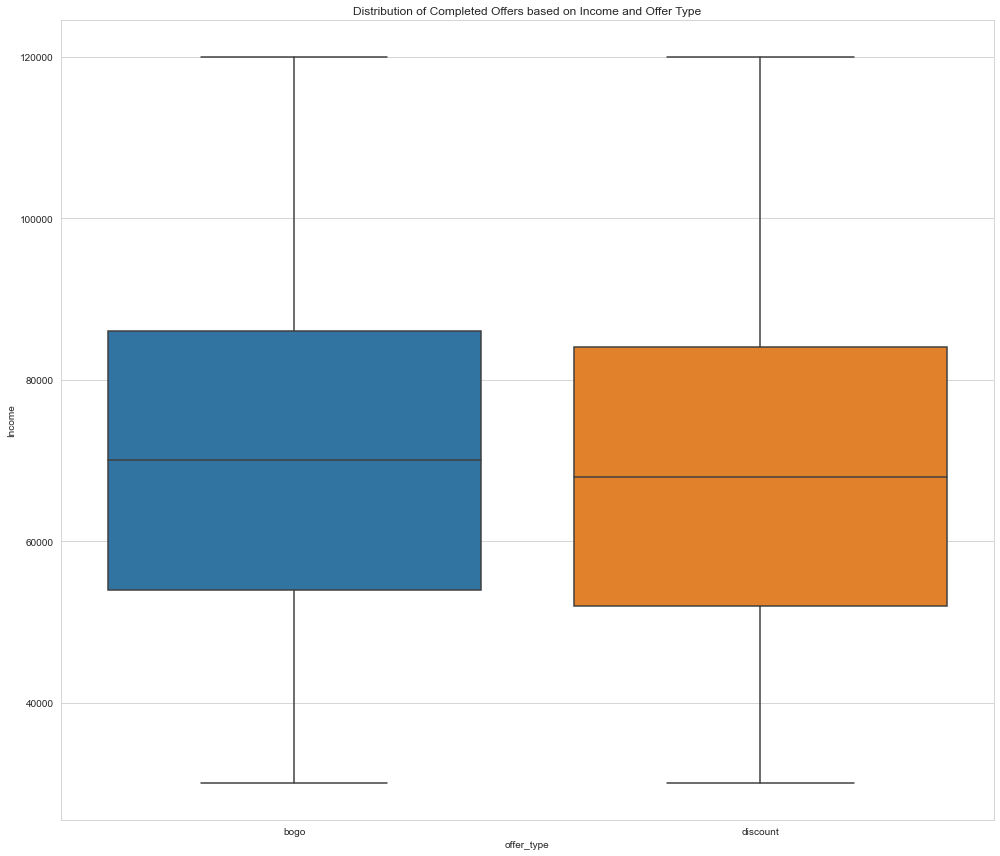

In [34]:
# Setting up the figure and axes
plt.figure(figsize=(14, 12))

# Plotting the distribution of completed offers based on income and offer type
sns.boxplot(data=completed_offers, x='offer_type', y='income')
plt.title('Distribution of Completed Offers based on Income and Offer Type')
plt.ylabel('Income')

plt.tight_layout()
plt.show()

### Build model to predict which users are more likely to view then complete offers

Predict if a customer would view then complete an offer or not

#### Steps: 
- Prepare the dataset
- Separate channels into columns and assign 0/1 values
- Create new column for category columns with 0/1 values (offer types, gender, event, age)
- Get only users who viewed offers then merge with users who completed offers
- Drop unneeded columns
- Fill nulls

In [35]:
df = merged_data_offer.copy()

dummies = pd.get_dummies(df['offer_type'])
df = pd.concat([df, dummies], axis=1)


dummies = pd.get_dummies(df['gender'])
df = pd.concat([df, dummies], axis=1)

dummies = pd.get_dummies(df['event'])
df = pd.concat([df, dummies], axis=1)


dummies = pd.get_dummies(df['age'])
df = pd.concat([df, dummies], axis=1)

df.head()

,person,event,time,offer_id,amount,reward_received,gender,age,year,income,...,children,YA,20s,30s,40s,50s,60s,70s,80+,NA
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0.0,F,70s,2017,100000.0,...,0,0,0,0,0,0,0,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0.0,F,70s,2017,100000.0,...,0,0,0,0,0,0,0,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,None,19.89,0.0,F,70s,2017,100000.0,...,0,0,0,0,0,0,0,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,5.0,F,70s,2017,100000.0,...,0,0,0,0,0,0,0,1,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,None,17.78,0.0,F,70s,2017,100000.0,...,0,0,0,0,0,0,0,1,0,0


In [36]:
# get offer viewed rows 
df_view = df[df['offer viewed']==1]
df_view.drop(['offer completed'], axis = 1, inplace=True)

df_view.head()

/Users/ifunanya/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,person,event,time,offer_id,amount,reward_received,gender,age,year,income,...,children,YA,20s,30s,40s,50s,60s,70s,80+,NA
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,F,70s,2017,100000.0,...,0,0,0,0,0,0,0,1,0,0
6,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,F,70s,2017,100000.0,...,0,0,0,0,0,0,0,1,0,0
11,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,408,ae264e3637204a6fb9bb56bc8210ddfd,0.0,0.0,F,70s,2017,100000.0,...,0,0,0,0,0,0,0,1,0,0
17,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,582,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0.0,F,70s,2017,100000.0,...,0,0,0,0,0,0,0,1,0,0
19,e2127556f4f64592b11af22de27a7932,offer viewed,18,2906b810c7d4411798c6938adc9daaa5,0.0,0.0,M,60s,2018,70000.0,...,0,0,0,0,0,0,1,0,0,0


In [37]:
df_complete = df[df['offer completed']==1][['offer_id','person', 'offer completed']]
df_complete.head()

,offer_id,person,offer completed
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,1
14,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,1
15,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,1
28,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,1
29,fafdcd668e3743c1bb461111dcafc2a4,e2127556f4f64592b11af22de27a7932,1


In [38]:
final_df = df_view.merge(df_complete,right_on=['offer_id','person'],left_on=['offer_id','person'],how='left')

final_df.head()

,person,event,time,offer_id,amount,reward_received,gender,age,year,income,...,YA,20s,30s,40s,50s,60s,70s,80+,NA,offer completed
0,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,F,70s,2017,100000.0,...,0,0,0,0,0,0,1,0,0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,F,70s,2017,100000.0,...,0,0,0,0,0,0,1,0,0,NaN
2,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,408,ae264e3637204a6fb9bb56bc8210ddfd,0.0,0.0,F,70s,2017,100000.0,...,0,0,0,0,0,0,1,0,0,1.0
3,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,582,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0.0,F,70s,2017,100000.0,...,0,0,0,0,0,0,1,0,0,1.0
4,e2127556f4f64592b11af22de27a7932,offer viewed,18,2906b810c7d4411798c6938adc9daaa5,0.0,0.0,M,60s,2018,70000.0,...,0,0,0,0,0,1,0,0,0,NaN


In [39]:
#drop un-needed columns
final_df.drop(['offer_type','gender','year','event','reward_received','person','offer_id',
               'time','offer received', 'offer viewed','age'], axis = 1, inplace=True)

In [40]:
final_df.fillna(0, inplace=True)

In [41]:
final_df.head()


,amount,income,reward,difficulty,duration,email,web,social,mobile,bogo,...,YA,20s,30s,40s,50s,60s,70s,80+,NA,offer completed
0,0.0,100000.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1,...,0,0,0,0,0,0,1,0,0,1.0
1,0.0,100000.0,0.0,0.0,3.0,1.0,0.0,1.0,1.0,0,...,0,0,0,0,0,0,1,0,0,0.0
2,0.0,100000.0,10.0,10.0,7.0,1.0,0.0,1.0,1.0,1,...,0,0,0,0,0,0,1,0,0,1.0
3,0.0,100000.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,1,...,0,0,0,0,0,0,1,0,0,1.0
4,0.0,70000.0,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0,...,0,0,0,0,0,1,0,0,0,0.0


In [42]:
final_df.columns

Index(['amount', 'income', 'reward', 'difficulty', 'duration', 'email', 'web',
       'social', 'mobile', 'bogo', 'discount', 'informational', 'F', 'M', 'O',
       'transaction', 'children', 'YA', '20s', '30s', '40s', '50s', '60s',
       '70s', '80+', 'NA', 'offer completed'],
      dtype='object')

### Build Model: Train, Predict and Score

In [43]:
def create_model(classifer, df):    
    """
    a function that will create a model: train -> predict -> score -> print result
              
    args:
    classifer: object of classifer
    df: dataframe ready for training that must have "offer completed" column
    
    """
    
    print('Training with ' + str(classifer).removesuffix('()') + "...")
    
    features = df.drop(['offer completed'], axis = 1)
    target = df['offer completed']
    
    # split dataset
    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42)

    # fit classifier
    clf = classifer.fit(X_train, y_train)

    # predict on training and test data
    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)

    # accuracy on training and test data
    score_train = accuracy_score( y_train , predict_train )
    score_test = accuracy_score( y_test , predict_test )

    # display classifier clf_result dict 
    print('Training Accuracy:' , score_train)
    print('Testing Accuracy :', score_test)

In [44]:
create_model(AdaBoostClassifier(), final_df)
create_model(GaussianNB(), final_df)
create_model(DecisionTreeClassifier(), final_df)
create_model(RandomForestClassifier(), final_df)

Training with AdaBoostClassifier...
Training Accuracy: 0.8063244729605866
Testing Accuracy : 0.8049769711968103
Training with GaussianNB...
Training Accuracy: 0.7878322639780019
Testing Accuracy : 0.7862789578607273
Training with DecisionTreeClassifier...
Training Accuracy: 0.8544683776351971
Testing Accuracy : 0.7795421736440503
Training with RandomForestClassifier...
Training Accuracy: 0.8544683776351971
Testing Accuracy : 0.7910909465869251


#### Model improvment with GridSearchCV
- Define the parameters
- Use GridSearch to find the best ones

###### Default parameters for AdaBoostClassifier:
- n_estimators default=50
- learning_rate=1.
- algorithm=’SAMME.R’

In [45]:
params = {
    'n_estimators': [40, 45, 50, 55, 60],
    'learning_rate' : [0.8,0.9,1,1.1,1.2],
    'algorithm':['SAMME', 'SAMME.R']
 }

#     'n_estimators': [50, 100,150,200],
#     'learning_rate' : [0.01,0.05,0.1,0.3,1],
#     'algorithm':['SAMME', 'SAMME.R']

df = final_df.copy()
features = df.drop(['offer completed'], axis = 1)
target = df['offer completed']
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42)
    
cv = GridSearchCV(AdaBoostClassifier(), param_grid=params, n_jobs = -1, scoring='accuracy')

cv.fit(X_train,y_train)

GridSearchCV(estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.8, 0.9, 1, 1.1, 1.2],
                         'n_estimators': [40, 45, 50, 55, 60]},
             scoring='accuracy')

In [46]:
# The best parameters
cv.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 40}

In [47]:
create_model(AdaBoostClassifier(algorithm='SAMME.R',learning_rate=0.9, n_estimators=45), final_df)

Training with AdaBoostClassifier(learning_rate=0.9, n_estimators=45)...
Training Accuracy: 0.8075160403299725
Testing Accuracy : 0.8055269127655187
